# Finding Best Method for Noise Reduction

It was previously found that calculating work hardening rate resulted in very noisy data, which was hard to filter down. It was therefore decided that the data should be filtered first, and then the work hardening rate filtered, in an attempt to reduce the noise as much as possible. This notebook explores the different ways of doing this, and produces a result of the best method.

The following code was taken from the 'plastic strain and work hardening' notebook. This first section imports the data, calculates true stress and strain, calculate the Young's modulus and then find the plastic strain and 'plastic stress'.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

def read_data(file):
    return np.loadtxt(file, usecols = (3,9), skiprows=10, delimiter=',')


RD_A = read_data('../Data/Instron/RD_Timet_A.csv')[0:2238]
RD_B = read_data('../Data/Instron/RD_Timet_B.csv')[0:2359]
TD_A = read_data('../Data/Instron/TD_Timet_A.csv')[0:2582]
TD_B = read_data('../Data/Instron/TD_Timet_B.csv')[0:2568]
FFD_A = read_data('../Data/Instron/45degree_Timet_A.csv')[0:3005]
FFD_B = read_data('../Data/Instron/45degree_Timet_B.csv')[0:2928]

#Converting to true stress and strain

def true_stress(stress,strain):
    return stress*(1+(strain/100))
def true_strain(strain):
    return (np.log(1+(strain/100)))

RD_A_True = np.column_stack((true_stress(RD_A[:,0],RD_A[:,1]),true_strain(RD_A[:,1])))
RD_B_True = np.column_stack((true_stress(RD_B[:,0],RD_B[:,1]),true_strain(RD_B[:,1])))
TD_A_True = np.column_stack((true_stress(TD_A[:,0],TD_A[:,1]),true_strain(TD_A[:,1])))
TD_B_True = np.column_stack((true_stress(TD_B[:,0],TD_B[:,1]),true_strain(TD_B[:,1])))
FFD_A_True = np.column_stack((true_stress(FFD_A[:,0],FFD_A[:,1]),true_strain(FFD_A[:,1])))
FFD_B_True = np.column_stack((true_stress(FFD_B[:,0],FFD_B[:,1]),true_strain(FFD_B[:,1])))

def youngs_modulus(e,m):
    return m*e

def find_m(stress,strain):
    e = (strain)[0:700]
    S = (stress)[0:700] 
    popt, pcov = curve_fit(youngs_modulus, e, S)
    return popt[0]

RD_A_m = find_m(RD_A_True[:,0],RD_A_True[:,1])
RD_B_m = find_m(RD_B_True[:,0],RD_B_True[:,1])
TD_A_m = find_m(TD_A_True[:,0],TD_A_True[:,1])
TD_B_m = find_m(TD_B_True[:,0],TD_B_True[:,1])
FFD_A_m = find_m(FFD_A_True[:,0],FFD_A_True[:,1])
FFD_B_m = find_m(FFD_B_True[:,0],FFD_B_True[:,1])

def cropped_plastic_strain(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return strain[crop1:crop2]-(stress[crop1:crop2]/m)

def cropped_plastic_stress(stress,strain,m):
    proof = stress/m + 0.002
    crop1 = np.argmax(np.greater(strain,proof)==True)
    crop2 = np.where(np.max(stress)==stress)[0][0]
    return stress[crop1:crop2]

RD_A_Plastic = np.array([cropped_plastic_stress(RD_A_True[:,0],RD_A_True[:,1],RD_A_m),cropped_plastic_strain(RD_A_True[:,0],RD_A_True[:,1],RD_A_m)]).T
RD_B_Plastic = np.array([cropped_plastic_stress(RD_B_True[:,0],RD_B_True[:,1],RD_B_m),cropped_plastic_strain(RD_B_True[:,0],RD_B_True[:,1],RD_B_m)]).T
TD_A_Plastic = np.array([cropped_plastic_stress(TD_A_True[:,0],TD_A_True[:,1],TD_A_m),cropped_plastic_strain(TD_A_True[:,0],TD_A_True[:,1],TD_A_m)]).T
TD_B_Plastic = np.array([cropped_plastic_stress(TD_B_True[:,0],TD_B_True[:,1],TD_B_m),cropped_plastic_strain(TD_B_True[:,0],TD_B_True[:,1],TD_B_m)]).T
FFD_A_Plastic = np.array([cropped_plastic_stress(FFD_A_True[:,0],FFD_A_True[:,1],FFD_A_m),cropped_plastic_strain(FFD_A_True[:,0],FFD_A_True[:,1],FFD_A_m)]).T
FFD_B_Plastic = np.array([cropped_plastic_stress(FFD_B_True[:,0],FFD_B_True[:,1],FFD_B_m),cropped_plastic_strain(FFD_B_True[:,0],FFD_B_True[:,1],FFD_B_m)]).T

### Creating a function for moving average

In [40]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

### Tests on reduction of noise

The following will test if it is better to use all data points of stress and strain with a moving average with a window size of 50, or every 10th data point with a moving average window size of 10.

#### Filtering the strain data

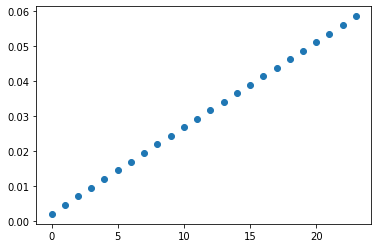

In [41]:
#Plotting every 50th value of the strain data to see how much noise there is
plt.plot(RD_A_Plastic[:,1][::50],'o');

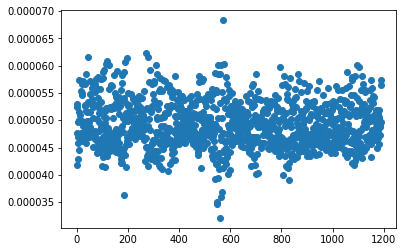

In [10]:
#Plotting the gradient of the strain data
plt.plot(np.gradient(RD_A_Plastic[:,1]),'o');

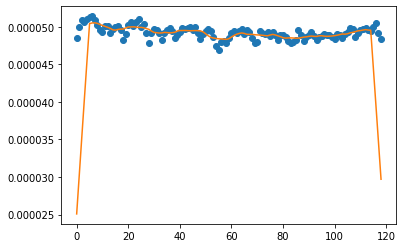

In [12]:
strain_gradient_data_10 = np.gradient(RD_A_Plastic[:,1][::10]/10)
plt.plot(strain_gradient_data_10,'o')
plt.plot(movingaverage(strain_gradient_data_10,10),'-');
#Plotting moving average of every 10th point with window of 10

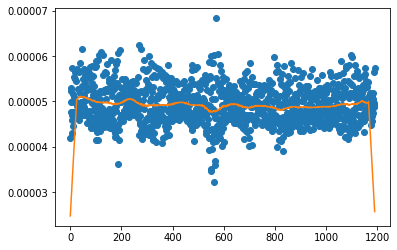

In [13]:
strain_gradient_data_50 = np.gradient(RD_A_Plastic[:,1][::])
plt.plot(strain_gradient_data_50,'o')
plt.plot(movingaverage(strain_gradient_data_50,50),'-');
#Plotting moving average of all points with window of 50

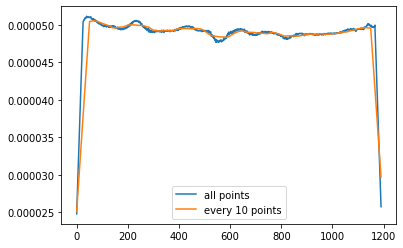

In [14]:
#Comparing the moving averages of the above 2 plots

x1 = np.linspace(0,1190,1190)
x2 = np.linspace(0,1190,119)

plt.plot(x1,movingaverage(strain_gradient_data_50,50),'-',label='all points')
plt.plot(x2,movingaverage(strain_gradient_data_10,10),'-',label='every 10 points')
plt.legend();

#### Filtering the stress data

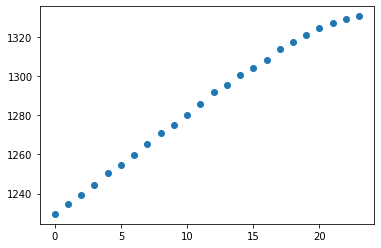

In [15]:
#Plotting every 50th value of the stress data to see how much noise there is
plt.plot(RD_A_Plastic[:,0][::50],'o');

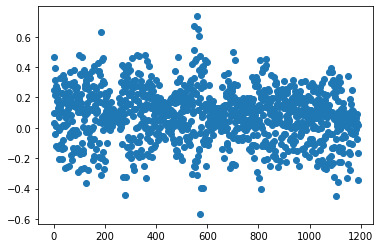

In [16]:
#Plotting the gradient of the stress data
plt.plot(np.gradient(RD_A_Plastic[:,0]),'o');

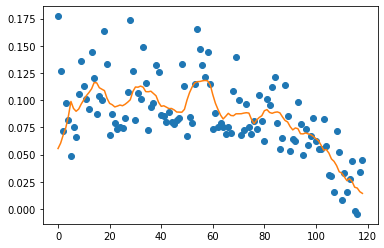

In [18]:
stress_gradient_data_10 = np.gradient(RD_A_Plastic[:,0][::10]/10)
plt.plot(stress_gradient_data_10,'o')
plt.plot(movingaverage(stress_gradient_data_10,10),'-');
#Plotting moving average of every 10th point with window of 10

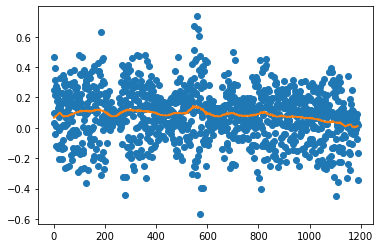

In [20]:
stress_gradient_data_50 = np.gradient(RD_A_Plastic[:,0][::])
plt.plot(stress_gradient_data_50,'o')
plt.plot(movingaverage(stress_gradient_data_50,50),'-');
#Plotting moving average of all points with window of 50

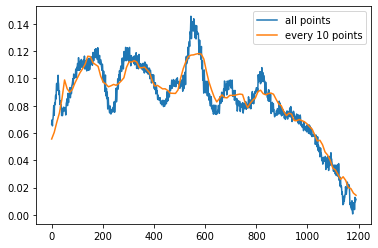

In [21]:
#Comparing the moving averages of the above 2 plots

plt.plot(x1,movingaverage(stress_gradient_data_50,50),'-',label='all points')
plt.plot(x2,movingaverage(stress_gradient_data_10,10),'-',label='every 10 points')
plt.legend();

#### Testing which method of noise reduction is better

In [22]:
stress = RD_A_Plastic[:,0]
strain = RD_A_Plastic[:,1]

stress_grad_50 = np.gradient(stress)
strain_grad_50 = np.gradient(strain)
moveav_stress_grad_50 = movingaverage(stress_grad_50,50)
moveav_strain_grad_50 = movingaverage(strain_grad_50,50)
whr_50 = moveav_stress_grad_50/moveav_strain_grad_50

stress_grad_10 = np.gradient(stress[::10]/10)
strain_grad_10 = np.gradient(strain[::10]/10)
moveav_stress_grad_10 = movingaverage(stress_grad_10,10)
moveav_strain_grad_10 = movingaverage(strain_grad_10,10) 
whr_10 = moveav_stress_grad_10/moveav_strain_grad_10

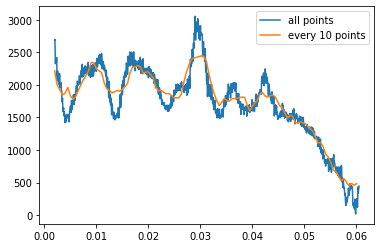

In [23]:
plt.plot(strain,whr_50,'-',label='all points')
plt.plot(strain[::10],whr_10,'-',label='every 10 points')
plt.legend();

This shows that the method using every 10th point and a moving average with window of 10 is the less noisy option for outputting the work hardening. It was also found that the same output was produced for both the gradient being calculated first and the moving average being calculated first.

We can also test to see if there are more ideal numbers than using 10 both for the step size and the moving average window size:

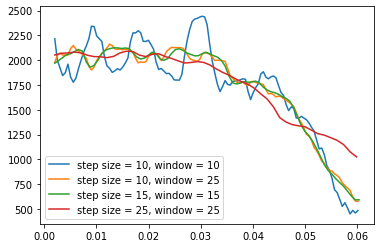

In [37]:
stress = RD_A_Plastic[:,0]
strain = RD_A_Plastic[:,1]

def reduce_noise(n,x):
    stress_grad_n = np.gradient(stress[::n]/n)
    strain_grad_n = np.gradient(strain[::n]/n)
    moveav_stress_grad_n = movingaverage(stress_grad_n,x)
    moveav_strain_grad_n = movingaverage(strain_grad_n,x) 
    return moveav_stress_grad_n/moveav_strain_grad_n
#n is the step size and x is the window size for the moving average

plt.plot(strain[::10],reduce_noise(10,10),'-',label='step size = 10, window = 10')
plt.plot(strain[::10],reduce_noise(10,25),'-',label='step size = 10, window = 25')
plt.plot(strain[::15],reduce_noise(15,15),'-',label='step size = 15, window = 15')
plt.plot(strain[::25],reduce_noise(25,25),'-',label='step size = 25, window = 25')
plt.legend();

From this testing, it has been decided that to reduce the noise a step size of 15 will be used alongside a moving average with window size 15. This gave the best reduction of noise without drasticall changing the overall shape of the graph